## Part 1

The A/B test was conducted between 2022-02-13 and 2022-02-19. Control group (A) - 1, treatment group (B) - 2.<br>
__H1:__ CTR will increase after the implementation of the new algorithm.<br>
Analyze the results using various statistical methods: T-test, Mann-Witney test, Laplace smoothing (𝛼=5), Bootstrap, Bucketization.

In [71]:
import pandahouse
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import hashlib
%matplotlib inline

sns.set()

Data from csv file

In [75]:
# Import from csv
df = pd.read_csv('Task_7.2_7.3.csv')
df

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,3,123580,13,48,0.270833
3,2,131473,14,134,0.104478
4,4,107323,5,31,0.161290
...,...,...,...,...,...
50144,0,27030,8,39,0.205128
50145,3,122758,30,198,0.151515
50146,1,132567,45,296,0.152027
50147,3,122190,19,65,0.292308


In [76]:
df.dtypes

exp_group      int64
user_id        int64
likes          int64
views          int64
ctr          float64
dtype: object

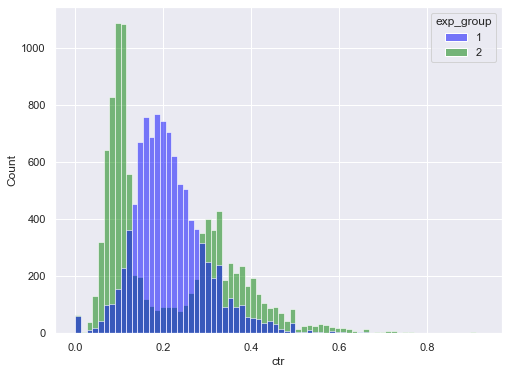

In [77]:
sns.set(rc={'figure.figsize':(8,6)})
groups = sns.histplot(data = df.query('exp_group == [1, 2]'), x='ctr', 
                      hue='exp_group', 
                      palette = ['blue', 'green'], 
                      alpha=0.5,
                      kde=False)

Group 2 (Treatment) the distribution is not normal.

### Methods

### 1. T-test

In [160]:
stats.ttest_ind(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr)

Ttest_indResult(statistic=0.7116545895251319, pvalue=0.4766869824114077)

p-value > 0.05

### 2. Laplace smoothing

$smoothedCTR = \frac{likes + \alpha * globalCTR}{views + \alpha}$, where $\alpha$ - hyperparameter, $globalCTR$ - CTR of a group<br>
<https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f#d2d3>

In [51]:
def get_smothed_ctr(likes, views, global_ctr, alpha):
    smothed_ctr = (likes + alpha * global_ctr) / (views + alpha)
    return smothed_ctr

In [52]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
print(global_ctr_1, global_ctr_2)

0.20802680490126244 0.1980601844115994


Global CTRs differ by approximately by 1%.

Choose 5 for 𝛼 

In [53]:
group1 = df[df.exp_group == 1].copy()
group1['smoothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2 = df[df.exp_group == 2].copy()
group2['smoothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

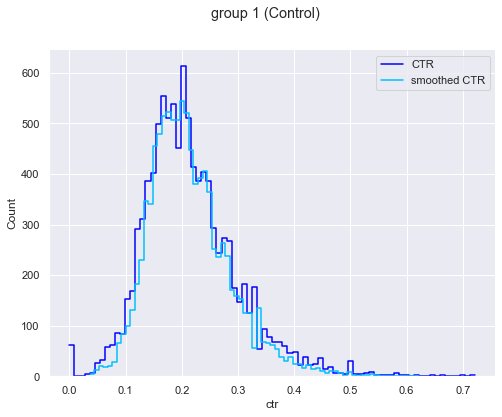

In [54]:
sns.histplot(group1.ctr, color='blue', element="step", fill=False)
sns.histplot(group1.smoothed_ctr, color='deepskyblue', element="step", fill=False)
plt.legend(labels=['CTR', 'smoothed CTR'])
plt.suptitle('group 1 (Control)')
sns.despine()

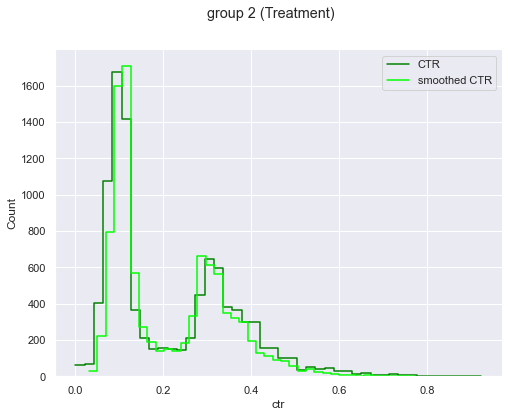

In [55]:
sns.histplot(group2.ctr, color='green', element="step", fill=False)
sns.histplot(group2.smoothed_ctr, color='lime', element="step", fill=False)
plt.legend(labels=['CTR', 'smoothed CTR'])
plt.suptitle('group 2 (Treatment)')
sns.despine()

In [56]:
stats.ttest_ind(group1.smoothed_ctr, group2.smoothed_ctr, equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

p-value < 0.05<br>
After smoothing the distributions became slightly narrower, t-test shows significant difference after this data transformation.

### 3. Poisson bootstrap
To compare group CTRs lets generate frequencies of occurrences of each observation in the subsample from Poisson distribution.

In [57]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [58]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

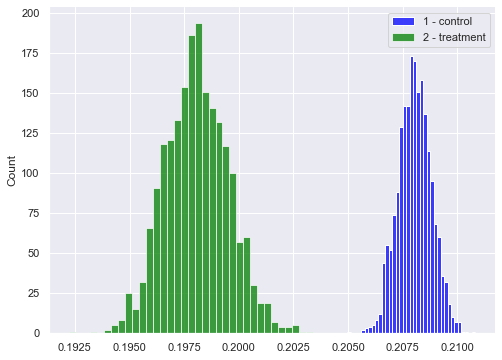

In [59]:
sns.histplot(ctr1, color='blue')
sns.histplot(ctr2, color='green')
plt.legend(labels=['1 - control', '2 - treatment'])
sns.despine()

<AxesSubplot:ylabel='Count'>

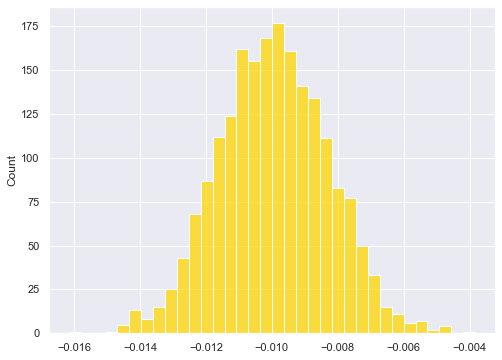

In [62]:
sns.histplot(ctr2 - ctr1, color='gold')

CTR in Group 2 is smaller than in Group 1. The distribution of difference doesn't include zero, meaning the difference is significant.

### 4. Mann-Whitney

In [63]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr)

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

p-value < 0.05

### 5. Bucketing

In [88]:
# Create bucketing function. 50 buckets for each group
def bucketing(id, salt='exp', n_groups=50):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [94]:
df12 = df.query('exp_group == [1, 2]').copy()

In [96]:
# Assign users to buckets
df12['bucket'] = df12.user_id.apply(bucketing)

In [97]:
df12

,exp_group,user_id,likes,views,ctr,bucket
1,1,18392,7,32,0.218750,35
3,2,131473,14,134,0.104478,0
5,2,32420,26,128,0.203125,11
6,2,24239,40,90,0.444444,11
8,1,27443,2,29,0.068966,8
...,...,...,...,...,...,...
50138,1,21697,2,22,0.090909,20
50140,2,1232,5,96,0.052083,23
50142,1,120653,15,74,0.202703,7
50146,1,132567,45,296,0.152027,28


In [99]:
df12.bucket.nunique()

50

In [100]:
# Find CTR in each bucket
df_50b = df12.groupby(['bucket', 'exp_group'], as_index=False).agg({'likes': 'sum', 'views': 'sum'})

df_50b = df_50b.assign(bucket_ctr = df_50b.likes / df_50b.views)
df_50b

,bucket,exp_group,likes,views,bucket_ctr
0,0,1,3286,15241,0.215603
1,0,2,2733,12312,0.221979
2,1,1,2786,13236,0.210487
3,1,2,2687,13254,0.202731
4,2,1,2996,14079,0.212799
...,...,...,...,...,...
95,47,2,2673,13688,0.195281
96,48,1,2736,13074,0.209270
97,48,2,2256,11164,0.202078
98,49,1,2834,13958,0.203038


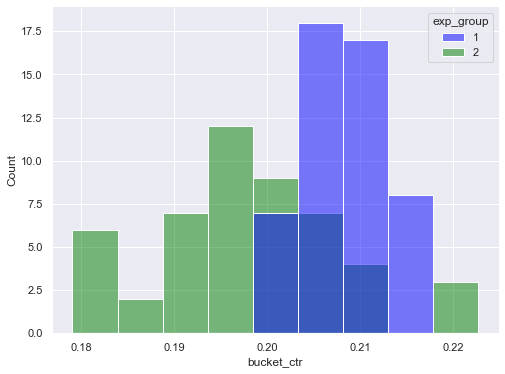

In [101]:
# Bucket CTR distributions by experimental group
sns.histplot(data=df_50b, x='bucket_ctr', hue='exp_group', palette = ['blue', 'green'])
sns.despine()

In [102]:
# Mann-Whitney
stats.mannwhitneyu(df_50b[df_50b.exp_group == 1].bucket_ctr, 
                   df_50b[df_50b.exp_group == 2].bucket_ctr)

MannwhitneyuResult(statistic=2091.0, pvalue=6.862487513520243e-09)

In [103]:
# t-test
stats.ttest_ind(df_50b[df_50b.exp_group == 1].bucket_ctr, 
                   df_50b[df_50b.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=6.359711095062542, pvalue=2.0791987070670997e-08)

Tests show significant difference between two groups. CTR in treatment group appeared to be smaller. Thus it is not recommended to implement changes. However, in Treatment group the distribution of metric became bimodal, which can mean that for certain users there was a positive impact. Further investigation can be made on this subject.

## Part 2
Same hypothesis. Apply Linearization metric to analyze CTRs.

### Linearization
The method is used for ratio metrics. The idea is to create (modify the original) and compare a new metric. In case the test shows significant difference between groups, the the same result is expected for the original metric. <br>
1) $likes_{linearized} = likes_{user} - globalCTR_{control} \times views_{user}$

2) Compare Linearized likes in both experimental groups with T-test<br>
<https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f#5eb5>

In [104]:
# Global CTR of Control group
ctr_control = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
ctr_control

0.20802680490126244

In [105]:
df12

,exp_group,user_id,likes,views,ctr,bucket
1,1,18392,7,32,0.218750,35
3,2,131473,14,134,0.104478,0
5,2,32420,26,128,0.203125,11
6,2,24239,40,90,0.444444,11
8,1,27443,2,29,0.068966,8
...,...,...,...,...,...,...
50138,1,21697,2,22,0.090909,20
50140,2,1232,5,96,0.052083,23
50142,1,120653,15,74,0.202703,7
50146,1,132567,45,296,0.152027,28


In [107]:
# Get linearized likes
df12['linearized_like'] = df12.likes - ctr_control*df12.views

In [108]:
df12

,exp_group,user_id,likes,views,ctr,bucket,linearized_like
1,1,18392,7,32,0.218750,35,0.343142
3,2,131473,14,134,0.104478,0,-13.875592
5,2,32420,26,128,0.203125,11,-0.627431
6,2,24239,40,90,0.444444,11,21.277588
8,1,27443,2,29,0.068966,8,-4.032777
...,...,...,...,...,...,...,...
50138,1,21697,2,22,0.090909,20,-2.576590
50140,2,1232,5,96,0.052083,23,-14.970573
50142,1,120653,15,74,0.202703,7,-0.393984
50146,1,132567,45,296,0.152027,28,-16.575934


Calculate p-value for linearized metrics using T-test. For comparison calculate it for the users CTRs as well:

In [158]:
print('Linearized metric:')
print('p-value=', stats.ttest_ind(df12[df12.exp_group == 1].linearized_like,
                df12[df12.exp_group == 2].linearized_like,
                equal_var=False)[1], sep='')
print('User CTR:')
print('p-value=', stats.ttest_ind(df12[df12.exp_group == 1].ctr,
                df12[df12.exp_group == 2].ctr,
                equal_var=False)[1], sep='')

Linearized metric:
p-value=9.439432187037644e-10
User CTR:
p-value=0.4780623130874935


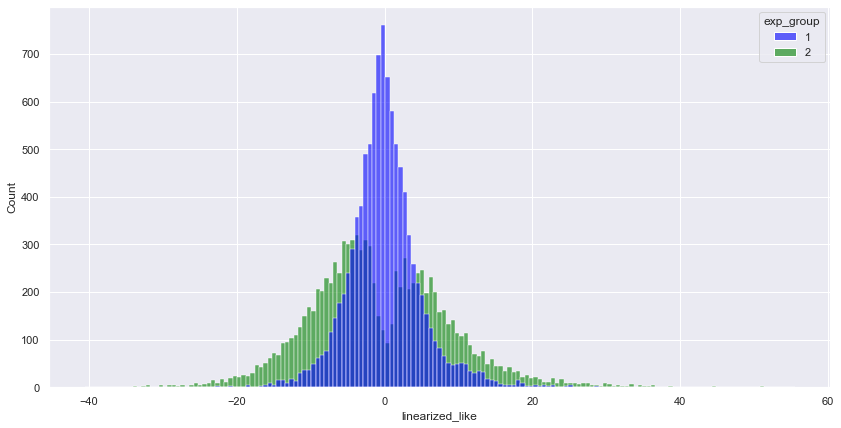

In [126]:
sns.set(rc={'figure.figsize':(14,7)})
groups = sns.histplot(data = df12, x='linearized_like', hue='exp_group', palette = ['blue', 'green'], alpha=0.6)

__Compare two other groups__:<br>
group 0 (Control) and 3 (Treatment):

In [115]:
df03 = df.query('exp_group == [0, 3]').copy()

In [129]:
# Global CTR of Control group (0)
ctr_control_0 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()
ctr_control_0

0.20823612262916305

In [118]:
# Get linearized likes
df03['linearized_like'] = df03.likes - ctr_control_0*df03.views

In [154]:
print('Linearized metric:')
print("p-value=", stats.ttest_ind(df03[df03.exp_group == 0].linearized_like,
                df03[df03.exp_group == 3].linearized_like,
                equal_var=False)[1], sep='')
print('User CTR:')
print('p-value=', stats.ttest_ind(df03[df03.exp_group == 0].ctr,
                df03[df03.exp_group == 3].ctr,
                equal_var=False)[1], sep='')

Linearized metric:
p-value=5.4914249479690016e-52
User CTR:
p-value=1.055849414662529e-43


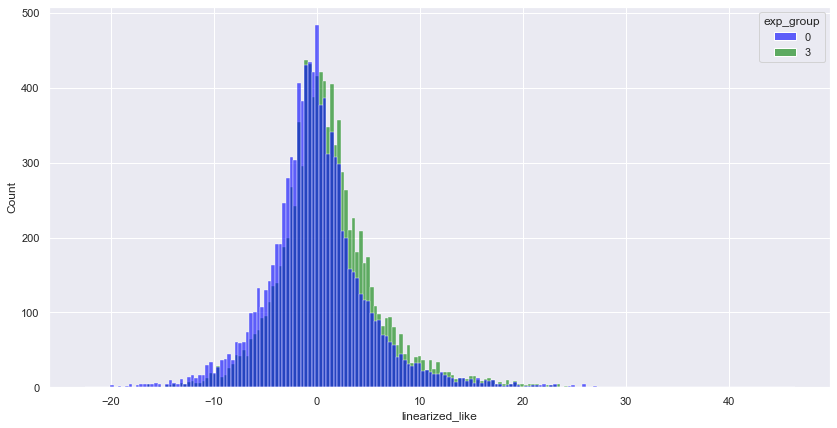

In [144]:
sns.set(rc={'figure.figsize':(14,7)})
groups = sns.histplot(data = df03, x='linearized_like', hue='exp_group', palette = ['blue', 'green'], alpha=0.6)

T-test worked better on linearized metric. It showed that there is difference between group 1 and 2. For groups 0 and 3 p-value is smaller than when comparing users CTRs.